In [34]:
# Import Libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
%matplotlib inline
from PIL import Image, ImageDraw, ImageColor, ImageFont
import os
import pandas as pd

In [2]:
def iou(pred, gt):
    '''Calculate IoU between two regions'''
    image = np.zeros((720, 1280))
    p = image.copy()
    
    xp11 = pred['x'] #xMin
    yp11 = pred['y'] #YMin
    xp12 = xp11 + pred['width']
    yp12 = yp11 + pred['height']
    p[yp11:yp12, xp11:xp12] = 1
    
    
    g = image.copy()
    xp21 = gt['x'] #xMin
    yp21 = gt['y'] #YMin
    xp22 = xp21 + gt['width']
    yp22 = yp21 + gt['height']
    g[yp21:yp22, xp21:xp22] = 1
    
    
    inter = cv2.bitwise_and(p, g)
    union = cv2.bitwise_or(p, g)
    
    iou = np.count_nonzero(inter) / np.count_nonzero(union)
    return iou

In [3]:
def fbeta_score(precision, recall, beta=2):
    '''Calculate fbeta score with beta=2'''
    return (1+beta**2)*precision*recall / ((beta**2)*precision + recall)

In [78]:
def F2SingleImage(predictions, groundTruths, iouThreshold):
    '''Get precision, recall, and f2 score of a single image after applying threshold'''
    tp = 0
    for pbox in predictions:
        iou_temp = []
        for gbox in groundTruths:
            iou_temp.append(iou(pbox, gbox))
        iou_max = max(iou_temp)
        if iou_max >= iouThreshold:
            tp += 1

    precision = tp / len(predictions)
    recall = tp / len(groundTruths)
    if tp == 0:
        score = 1
    else:
        score = fbeta_score(precision, recall, )
    return (precision, recall, score)
    

In [104]:
def plot_img_camp(path, pre_bboxes, gt_bboxes):
    '''Plot the detection result and ground truth on the same image'''
    img = Image.open(path)
    fnt = ImageFont.truetype("/Library/Fonts/Arial.ttf", 40)
    content1 = 'Detected: ' + str(len(pre_bboxes)) 
    content2 = 'GroundTruth: ' + str(len(gt_bboxes))

    for box in pre_bboxes:
        shape = [(box['x'], box['y']), (box['x']+box['width'], box['y']+box['height'])]
        ImageDraw.Draw(img).rectangle(shape, outline="red", width=3)
    for box in gt_bboxes:
        shape = [(box['x'], box['y']), (box['x']+box['width'], box['y']+box['height'])]
        ImageDraw.Draw(img).rectangle(shape, outline="blue", width=3)
    ImageDraw.Draw(img).text((5, 5), content1, fill="red", font=fnt)
    ImageDraw.Draw(img).text((5, 50), content2, fill="blue", font=fnt)
    display(img)

In [35]:
# Load meta data
data_df = pd.read_csv('train.csv')
data_df['annotations'] = data_df['annotations'].map(lambda x : eval(x))
data_df['filepath'] = data_df.apply(lambda x : f"train_images/video_{x.video_id}/{x.video_frame}.jpg", axis=1)
data_df

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filepath
0,0,40258,0,0,0-0,[],train_images/video_0/0.jpg
1,0,40258,1,1,0-1,[],train_images/video_0/1.jpg
2,0,40258,2,2,0-2,[],train_images/video_0/2.jpg
3,0,40258,3,3,0-3,[],train_images/video_0/3.jpg
4,0,40258,4,4,0-4,[],train_images/video_0/4.jpg
...,...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[],train_images/video_2/10755.jpg
23497,2,29859,10756,2984,2-10756,[],train_images/video_2/10756.jpg
23498,2,29859,10757,2985,2-10757,[],train_images/video_2/10757.jpg
23499,2,29859,10758,2986,2-10758,[],train_images/video_2/10758.jpg


In [ ]:
# Load detection result dictionary
output_dir = 'labels/'

In [79]:
# Get precision, recall, and f2 score of each testing image with confidence threshold from 0.3 to 0.8 every 0.05
precision_lst, recall_lst = [[],[],[],[],[],[],[],[],[],[],[]], [[],[],[],[],[],[],[],[],[],[],[]]
f2_score_lst = [[],[],[],[],[],[],[],[],[],[],[]]

for file in tqdm(os.listdir(output_dir)):
#     read all output files from YOLO
    idx = file.find('_')
    filepath = 'train_images/video_' + file[0] + '/' + file[2:idx] + '.jpg'
    path = os.path.join(output_dir, file)
    
    pred_bboxes = []
    with open(path) as f:
#         get predict bounding boxes and scale data
        for line in f.readlines():
            (xc, yc, w, h) = line.strip('\n').split(' ')[1:]
            width = int(eval(w) * 1280)
            height = int(eval(h) * 720)
            x = int(eval(xc) * 1280 - 0.5 * width)
            y = int(eval(yc) * 720 - 0.5 * height)
            pred_bboxes.append({'x': x, 'y':y, 'width':width, 'height':height})
            
#     get ground truth boxes
    gt_bboxes = data_df[data_df.filepath == filepath].iloc[0]['annotations']
    
#     Det metrics with different confidence threshold
    for i in range(11):
        confidence_threshold = round(0.3 + 0.05 * i, 2)
        (precision, recall, score) = F2SingleImage(pred_bboxes, gt_bboxes, confidence_threshold)
        f2_score_lst[i].append(score)
        precision_lst[i].append(precision)
        recall_lst[i].append(recall)


100%|█████████████████████████████████████████| 401/401 [05:10<00:00,  1.29it/s]


In [84]:
# Get avarage f2 Score of different confidence threshold
x = []
y = []
for i in range(11):
    confidence_threshold = round(0.3 + 0.05 * i, 2)
    f2_score_avg = round(np.average(f2_score_lst[i]), 3)
    x.append(confidence_threshold)
    y.append(f2_score_avg)
#     precision_avg = np.average(precision_lst[i])
#     recall_avg = np.average(recall_lst[i])
#     f2_score_avg = fbeta_score(precision_avg, recall_avg, )
    print(f"Confidence threshold: {confidence_threshold:.2f}\t f2 score: {f2_score_avg:.3f}")

Confidence threshold: 0.30	 f2 score: 0.866
Confidence threshold: 0.35	 f2 score: 0.864
Confidence threshold: 0.40	 f2 score: 0.862
Confidence threshold: 0.45	 f2 score: 0.861
Confidence threshold: 0.50	 f2 score: 0.857
Confidence threshold: 0.55	 f2 score: 0.851
Confidence threshold: 0.60	 f2 score: 0.840
Confidence threshold: 0.65	 f2 score: 0.825
Confidence threshold: 0.70	 f2 score: 0.802
Confidence threshold: 0.75	 f2 score: 0.791
Confidence threshold: 0.80	 f2 score: 0.816


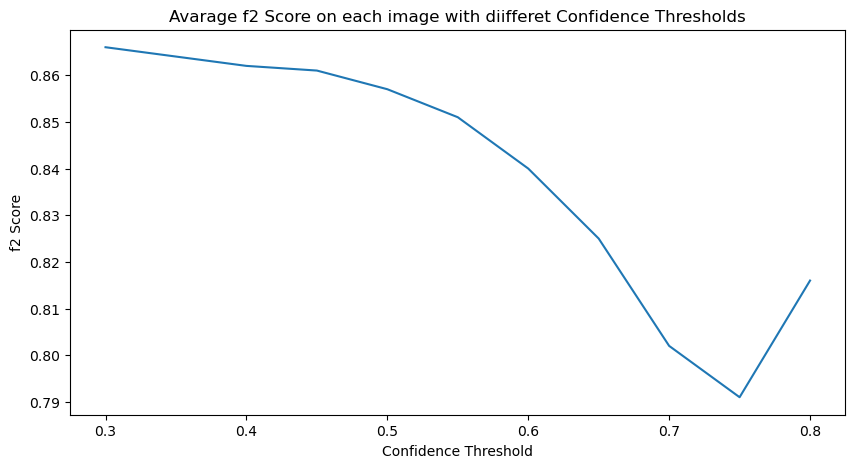

In [88]:
# Plot line graph of Confidence Threshold and Avarage F2 Score
plt.figure(figsize=(10,5))
plt.title("Avarage f2 Score on each image with diifferet Confidence Thresholds")
plt.xlabel("Confidence Threshold")
plt.ylabel("f2 Score")
plt.plot(x,y)


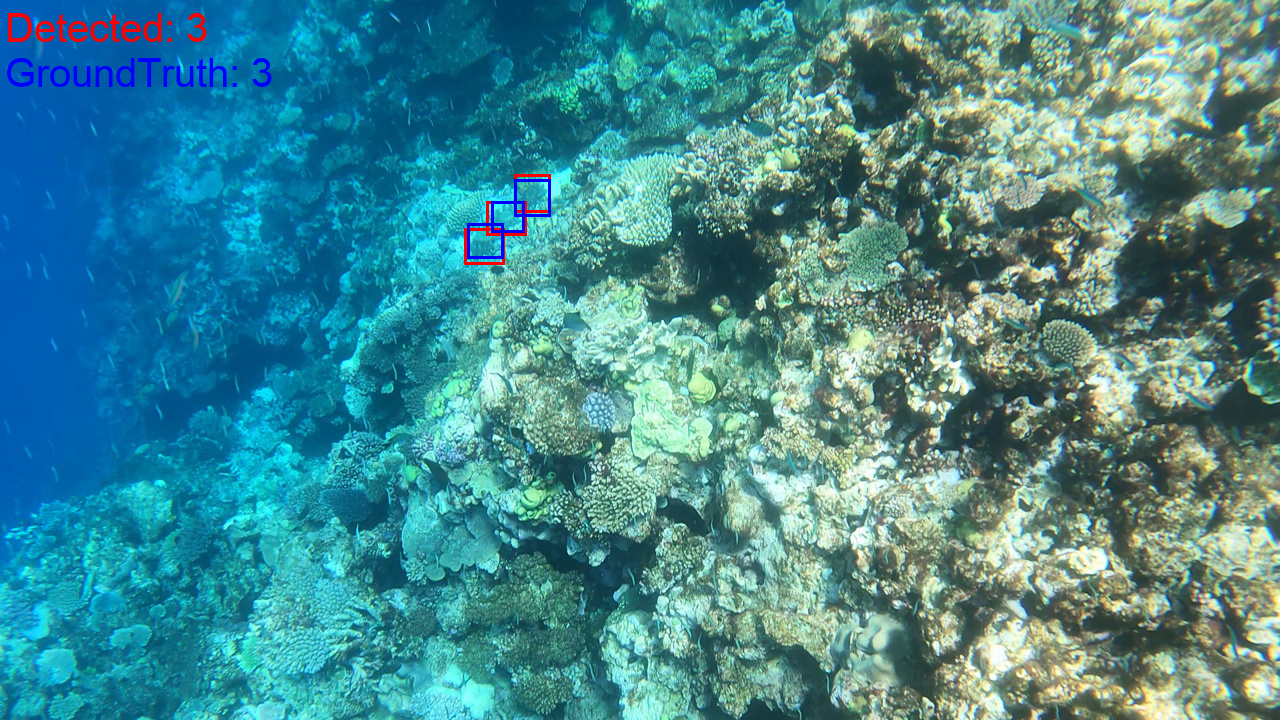

In [109]:
# Show a sample comparision result
file = '2-6251_jpg.rf.cf7eec55e7116179fb91f8c95e5a6e01.txt'
idx = file.find('_')
filepath = 'train_images/video_' + file[0] + '/' + file[2:idx] + '.jpg'
path = os.path.join(output_dir, file)
pred_bboxes = []
with open(path) as f:
    for line in f.readlines():
        (xc, yc, w, h) = line.strip('\n').split(' ')[1:]
        width = int(eval(w) * 1280)
        height = int(eval(h) * 720)
        x = int(eval(xc) * 1280 - 0.5 * width)
        y = int(eval(yc) * 720 - 0.5 * height)
        pred_bboxes.append({'x': x, 'y':y, 'width':width, 'height':height})
gt_bboxes = data_df[data_df.filepath == filepath].iloc[0]['annotations']

plot_img_camp(filepath, pred_bboxes, gt_bboxes)